In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Random response

In [ ]:
def rand_response(bin_resp, p):
  trial = np.random.binomial(1, p)
  if trial:
    return bin_resp
  else:
    return 1-bin_resp

def rr_sum_estimator(rand_resps, p):
  q = 1-p
  est = (rand_resps.sum() - len(rand_resps)*q)/(p-q)
  return est

def rr_mean_estimator(rand_resps, p):
  est = rr_sum_estimator(rand_resps, p)/len(rand_resps)
  return est 

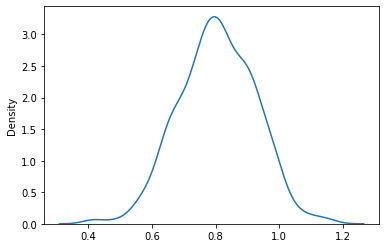

In [ ]:
p = 0.7
true_resps = 80
total_resps = 100
responses = list(np.ones(true_resps))+list(np.zeros(total_resps - true_resps))

means = []
for i in range(1000):
  rand_resps = [rand_response(resp, p) for resp in responses]
  rand_resps = pd.Series(rand_resps)
  est_mean = rr_mean_estimator(rand_resps, p)
  means.append(est_mean)

sns.kdeplot(means)
plt.show()

## Generalized Random response

In [ ]:
def grr_multinomial(p, d):
    pvals = [p] +[(1-p)/(d-1)]*(d-1)
    trial = np.random.multinomial(1, pvals)
    return trial

def gen_rand_response(resp, p, dom):
    
    size_d = len(dom)
    trial = grr_multinomial(p, size_d)
    ind, = np.where(trial==1)
    resp_t = ind[0]

    if resp_t == 0:
      return resp
    else:
      dom_rest = [i for i in dom if i != resp]
      return dom_rest[resp_t-1]

def grr_sum_estimator(rand_resps, n, p, dom):
  q = (1-p)/(len(dom)-1)
  est = (rand_resps.count() - n*q)/(p-q)
  return est

def grr_mean_estimator(rand_resps, n, p, dom):
  sum = grr_sum_estimator(rand_resps, n, p, dom)
  est = sum/n
  return est

In [ ]:
# for the binary case
p = 0.7
domain = [0, 1]
true_resps = 800
total_resps = 1000
responses = list(np.ones(true_resps))+list(np.zeros(total_resps - true_resps))

sums = {i:[] for i in domain}
rand_resps = [gen_rand_response(resp, p, domain) for resp in responses]
rand_resps = pd.Series(rand_resps)

for i in domain:
  resps_i = rand_resps[rand_resps == i]
  est = grr_sum_estimator(resps_i, total_resps, p, domain)
  sums[i].append(est)
  
print(sums)

{0: [182.4999999999999], 1: [817.5]}


In [ ]:
# for the multinomial case
p = 0.7
domain = [0,1,2]
total_resps = 1000
responses = list(np.zeros(200))+list(np.ones(500))+list(np.ones(300)*2)

sums = {i:[] for i in domain}
rand_resps = [gen_rand_response(resp, p, domain) for resp in responses]
rand_resps = pd.Series(rand_resps)

for i in domain:
  resps_i = rand_resps[rand_resps == i]
  est = grr_sum_estimator(resps_i, total_resps, p, domain)
  sums[i].append(est)
  
print(sums)

{0: [198.18181818181816], 1: [483.6363636363637], 2: [318.1818181818182]}


## Laplace Mechanism

In [ ]:
def laplace_mechanism(v, k, epsilon):
  return v + np.random.laplace(0, k/epsilon)

In [ ]:
laplace_mechanism(1, 1, 0.1)

3.652765845456324

## Discretization primitive

In [ ]:
def discretize(v):
  p = (1+v)/2
  trial = np.random.binomial(1, p)
  
  if trial:
    return 1
  else:
    return -1


## Algorithm 1: Privacy Mechanism: MR

In [ ]:
def MR_mechanism(g, v, epsilon_1, epsilon_2, domain):

  d = len(domain)
  p = math.exp(epsilon_1) / (math.exp(epsilon_1) + d - 1)
  g_prime = gen_rand_response(g, p, domain)

  if g == g_prime:
    v_prime = v
  else:
    v_prime = 0

  v_prime = discretize(v_prime)
  
  p = math.exp(epsilon_2) / (1 + math.exp(epsilon_2)) 
  v_prime = gen_rand_response(v_prime, p, [-1,1]) # Fixed from [0,1]

  return g_prime, v_prime


## Algorithm 2: Privacy Mechanism: ML

In [ ]:
def ML_mechanism(g, v, epsilon_1, epsilon_2, domain, k):

  d = len(domain)
  p = math.exp(epsilon_1) / (math.exp(epsilon_1) + d - 1)
  g_prime = gen_rand_response(g, p, domain)

  if g == g_prime:
    v_prime = laplace_mechanism(v, 1, epsilon_2)
  else:
    v_prime = laplace_mechanism(0, k, epsilon_2)

  return g_prime, v_prime



## Experimental Setup
> This is a simulation of the setting shown in the paper with the following assumptions:
1. There is a protected attribute P = {0, 1}
2. The performance measure is TPR, with mean_TPR(0) = 90% and mean_TPR(1) = 70%
3. The TPR's per group are distributed with a normal distribution
4. We take balanced samples with replacement for each iteration   



In [ ]:
m_0 = 0.9
m_1 = 0.7
delta_m = abs(m_0 - m_1)
size = 1000
stddev = 0.01 
values_0 = np.random.normal(m_0, stddev, size)
values_1 = np.random.normal(m_1, stddev, size)

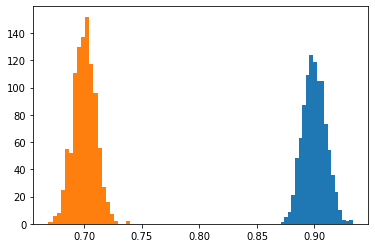

In [ ]:
plt.subplot()
plt.hist(values_0, bins=20)
plt.hist(values_1, bins=20)
plt.show()

## Configurations

In [ ]:
domain = [0,1]
num_runs = 10
K = 10e3 # num clients
epsilons =  [0.01, 0.10, 1, 10]

In [ ]:
data = pd.DataFrame({'g':list(np.zeros(size))+list(np.ones(size)),\
                     'v':list(values_0)+list(values_1)})
data

,g,v
0,0.0,0.907585
1,0.0,0.893582
2,0.0,0.902298
3,0.0,0.903738
4,0.0,0.886267
...,...,...
1995,1.0,0.704696
1996,1.0,0.693928
1997,1.0,0.703320
1998,1.0,0.698107


In [ ]:
sample = data.groupby('g', group_keys=False).sample(n=int(K/2),\
                                                    replace=True).\
                                                    reset_index(drop=True).\
                                                    reset_index()
sample


,index,g,v
0,0,0.0,0.894330
1,1,0.0,0.904255
2,2,0.0,0.905319
3,3,0.0,0.886230
4,4,0.0,0.903937
...,...,...,...
9995,9995,1.0,0.690298
9996,9996,1.0,0.692878
9997,9997,1.0,0.694403
9998,9998,1.0,0.712742


## Mechanism estimators and optimal privacy budgets

In [ ]:
def MRG_estimator(resps, epsilon_1, epsilon_2, n, domain):
  a = math.exp(epsilon_1)/(math.exp(epsilon_1)+len(domain)-1)
  b = math.exp(epsilon_2)/(math.exp(epsilon_2)+1)
  est = resps.sum()/(a*n*(2*b - 1))
  return est

def MLAP_estimator(resps, epsilon_1, n, domain):
    a = math.exp(epsilon_1)/(math.exp(epsilon_1)+len(domain)-1)
    est = resps.sum()/(a*n)
    return est

def MR_privacy_budget(epsilon):
  
  # optimal allocation that minimizes 
  # the MSE under LDP constraint (Sec 5.2)
  
  epsilon_1 = epsilon
  epsilon_2 = epsilon

  return epsilon_1, epsilon_2

def ML_privacy_budget(epsilon):
  
  # minimize MSE by setting epsilon_2 = epsilon
  # and finding the optimal k (Sec 5.2)

  epsilon_2 = epsilon

  if epsilon >= 2/3:
    k = epsilon
    epsilon_1 = math.log(2/epsilon) + epsilon - 1
  else:
    k = 2/3
    epsilon_1 = math.log(3) - (epsilon/2)
  
  return epsilon_1, epsilon_2, k

In [ ]:
epsilon = 1

## MR mechanism

In [ ]:
epsilon_1, epsilon_2 = MR_privacy_budget(epsilon)

In [ ]:
def MR_apply(df, epsilon_1, epsilon_2, domain):
    g_prime, v_prime = MR_mechanism(df.g.values[0], df.v.values[0],
                                    epsilon_1, epsilon_2, domain)
    return pd.DataFrame({'g_prime':[g_prime], 'v_prime':[v_prime]})

In [ ]:
perturbed = sample.groupby(['index','g','v']).\
   apply(lambda df: MR_apply(df,epsilon_1=epsilon_1, epsilon_2=epsilon_2,domain=domain))

perturbed = perturbed.reset_index().drop('level_3',axis=1)
perturbed

,index,g,v,g_prime,v_prime
0,0,0.0,0.894330,0.0,1
1,1,0.0,0.904255,0.0,1
2,2,0.0,0.905319,0.0,1
3,3,0.0,0.886230,1.0,1
4,4,0.0,0.903937,0.0,-1
...,...,...,...,...,...
9995,9995,1.0,0.690298,1.0,-1
9996,9996,1.0,0.692878,1.0,1
9997,9997,1.0,0.694403,1.0,1
9998,9998,1.0,0.712742,1.0,1


## Estimating *Count(g)*

In [ ]:
sums = {i:[] for i in domain}
for i in domain:
  resps_i = perturbed[perturbed.g_prime == i].g_prime
  p = math.exp(epsilon) / (math.exp(epsilon) + len(domain) - 1)
  est = grr_sum_estimator(resps_i, K, p, domain)
  sums[i].append(est)
sums

{0: [4997.836046586262], 1: [5002.163953413738]}

## Estimating *v*

In [ ]:
means = {i:[] for i in domain}
for i in domain:
  resps_i = perturbed[perturbed.g_prime == i].v_prime
  est = MRG_estimator(resps_i, epsilon_1, epsilon_2, K/2, domain)
  means[i].append(est)
means

{0: [0.864920002278573], 1: [0.6944224248273554]}

In [ ]:
delta_m_hat = abs(means[0][0] -  means[1][0])
delta_m_hat

0.17049757745121763

## ML mechanism

In [ ]:
epsilon = 1

In [ ]:
epsilon_1, epsilon_2, k = ML_privacy_budget(epsilon)

In [ ]:
print(epsilon_1, epsilon_2, k)

0.6931471805599454 1 1


In [ ]:
def ML_apply(df, epsilon_1, epsilon_2, domain, k):
    g_prime, v_prime = ML_mechanism(df.g.values[0], df.v.values[0],
                                    epsilon_1, epsilon_2, domain, k)
    return pd.DataFrame({'g_prime':[g_prime], 'v_prime':[v_prime]})

In [ ]:
perturbed = sample.groupby(['index','g','v']).\
   apply(lambda df: ML_apply(df,epsilon_1=epsilon_1, epsilon_2=epsilon_2, domain=domain, k=k))

perturbed = perturbed.reset_index().drop('level_3',axis=1)
perturbed

,index,g,v,g_prime,v_prime
0,0,0.0,0.894330,1.0,-0.295864
1,1,0.0,0.904255,1.0,-1.690943
2,2,0.0,0.905319,0.0,0.373968
3,3,0.0,0.886230,0.0,1.828470
4,4,0.0,0.903937,1.0,-0.255128
...,...,...,...,...,...
9995,9995,1.0,0.690298,1.0,-3.000871
9996,9996,1.0,0.692878,1.0,2.242727
9997,9997,1.0,0.694403,1.0,0.333839
9998,9998,1.0,0.712742,1.0,-0.444312


In [ ]:
means = {i:[] for i in domain}
for i in domain:
  resps_i = perturbed[perturbed.g_prime == i].v_prime
  est = MLAP_estimator(resps_i, epsilon_1, K/2, domain)
  means[i].append(est)
means

{0: [0.9336891669875145], 1: [0.7414775388226409]}

In [ ]:
delta_m_hat = abs(means[0][0] -  means[1][0])
delta_m_hat

0.19221162816487358

## MSE for the performance gap estimator of MR and ML estimators

### Configuration

In [ ]:
epsilons = [0.1, 1, 2, 3, 4]
n_G = 10e2 # different from paper i.e. 10e4
n_G_bar = n_G
K = n_G + n_G_bar
num_iters = 30
domain = [0, 1] # the domain of the group variable

In [ ]:
sample = data.groupby('g', group_keys=False).sample(n=int(n_G),\
                                                    replace=True).\
                                                    reset_index(drop=True).\
                                                    reset_index()
sample

,index,g,v
0,0,0.0,0.893615
1,1,0.0,0.899401
2,2,0.0,0.895501
3,3,0.0,0.887409
4,4,0.0,0.888668
...,...,...,...
1995,1995,1.0,0.715145
1996,1996,1.0,0.714652
1997,1997,1.0,0.707601
1998,1998,1.0,0.713075


In [ ]:
MR_perf_gaps = {epsilon:[] for epsilon in epsilons}
ML_perf_gaps = {epsilon:[] for epsilon in epsilons}

for epsilon in epsilons:
  
  # privacy budget - MR
  epsilon_1_mr, epsilon_2_mr = MR_privacy_budget(epsilon)

  # privacy budget - ML
  epsilon_1_ml, epsilon_2_ml, k = ML_privacy_budget(epsilon)  

  for i in range(num_iters):


    # #### MR mechanism

    # perturb - MR
    perturbed = sample.groupby(['index','g','v']).\
       apply(lambda df: MR_apply(df,epsilon_1=epsilon_1_mr, epsilon_2=epsilon_2_mr,domain=domain))
   
    perturbed = perturbed.reset_index().drop('level_3',axis=1)
    
    
    # aggregate - MR
    v_est = {d: None for d in domain}
    for d in domain:
      resps_d = perturbed[perturbed.g_prime == d].v_prime
      est = MRG_estimator(resps_d, epsilon_1_mr, epsilon_2_mr, K/2, domain)
      v_est[d] = est
    
    # performance gap esitamtor - MR 
    delta_m_hat = abs(v_est[0] - v_est[1])
    MR_perf_gaps[epsilon].append(delta_m_hat)

    #### ML Mechanism

    # perturb - ML
    perturbed = sample.groupby(['index','g','v']).\
   apply(lambda df: ML_apply(df,epsilon_1=epsilon_1_ml, epsilon_2=epsilon_2_ml, domain=domain, k=k))

    perturbed = perturbed.reset_index().drop('level_3',axis=1)
    
    # aggregate - ML
    v_est = {d: None for d in domain}
    for d in domain:
      resps_d = perturbed[perturbed.g_prime == d].v_prime
      est = MLAP_estimator(resps_d, epsilon_1_ml, K/2, domain)
      v_est[d] = est
    
    delta_m_hat = abs(v_est[0] -  v_est[1])
    ML_perf_gaps[epsilon].append(delta_m_hat)
    


In [ ]:
MR_perf_gaps

{0.1: [1.9826814987753378,
  0.9150837686655404,
  0.6863128264991556,
  0.6100558457770271,
  0.991340749387669,
  3.1265362096072637,
  1.4488826337204392,
  0.07625698072212839,
  0.7625698072212838,
  0.5337988650548987,
  0.0,
  3.6603350746621626,
  0.07625698072212828,
  1.4488826337204392,
  0.5337988650548987,
  0.9150837686655406,
  0.4575418843327703,
  0.5337988650548986,
  1.7539105566089528,
  0.6863128264991555,
  1.2201116915540544,
  0.991340749387669,
  0.7625698072212836,
  0.4575418843327702,
  0.38128490361064193,
  0.07625698072212833,
  0.9150837686655406,
  0.15251396144425677,
  2.974022248163007,
  0.6863128264991555],
 1: [0.2664024647675276,
  0.0828807668165642,
  0.01184010954522341,
  0.10656098590701113,
  0.09472087636178761,
  0.053280492953505565,
  0.05920054772611727,
  0.39664366976498555,
  0.14208131454268136,
  0.21312197181402215,
  0.09472087636178761,
  0.30192279340319805,
  0.39072361499237374,
  0.23088213613185726,
  0.4380840531732676,
 

In [ ]:
ML_perf_gaps

{0.1: [0.24490306427181807,
  0.23465039315761005,
  0.5955674824946675,
  0.3223398930011543,
  1.0937304298867856,
  0.7498885461096271,
  0.2740229642837857,
  0.4425666306790387,
  1.05279250504921,
  0.3210118524206119,
  0.5325049150957075,
  0.43241748129572855,
  0.04429110874321118,
  0.17820047486057367,
  0.11781736734458481,
  0.3156150187876074,
  0.10563593510248948,
  2.103369434979353,
  1.243155192232114,
  0.18413024381412013,
  0.9332474152636484,
  0.6269209247722594,
  0.6523716198874048,
  0.2786394937955605,
  0.20363174692503572,
  0.12464185215249002,
  1.263505593349264,
  0.3397952368537223,
  0.17948094735920117,
  0.4298334754236486],
 1: [0.21933596767606578,
  0.106934648985758,
  0.1665147132379693,
  0.3293838967181325,
  0.2943333567276677,
  0.20782487935301408,
  0.11160560733886915,
  0.10794505276512745,
  0.029455218598279265,
  0.10971416183894145,
  0.2909276872742871,
  0.2978851827192236,
  0.00666193545499727,
  0.3505903176465137,
  0.158789

In [ ]:
#MR_mse = {epsilon:np.var(MR_perf_gaps[epsilon]) for epsilon in epsilons}

In [ ]:
def mean_squared_error(perf_gaps, delta_m):
  pf_gaps = np.array(perf_gaps)
  sq_errors = (pf_gaps - delta_m)**2
  mse = np.mean(sq_errors)
  return mse

In [ ]:
MR_mse = {epsilon:mean_squared_error(MR_perf_gaps[epsilon],delta_m) for epsilon in epsilons}
print('MR estimator means squared error',MR_mse)

MR estimator means squared error {0.1: 1.42904782591254, 1: 0.018150161487403213, 2: 0.0032297659024980957, 3: 0.0013969819430475964, 4: 0.0012113677980837927}


In [ ]:
ML_mse = {epsilon:mean_squared_error(ML_perf_gaps[epsilon],delta_m) for epsilon in epsilons}
print('ML estimator means squared error',ML_mse)

ML estimator means squared error {0.1: 0.30506099824659605, 1: 0.008738535791167243, 2: 0.0029113972649435662, 3: 0.001477753586501159, 4: 0.0006847219682369722}
